<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S11/EVA4_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
# !pip install albumentations==0.4.5
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import sys
import torch.nn as nn
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


##Add Google Drive path to system path

In [3]:
os.chdir('./drive/My Drive/colab_notebooks/S11/')

!ls

acc_trn_vs_tst.jpg	     data	     lr_range.py  train_test_loader.py
albumentation_transforms.py  EVA4_S11.ipynb  __pycache__  visualise_acc.py
BaseModel.py		     get_images.py   testing.py   visualise_loss_acc.py
config.py		     lrfinder.py     training.py


##Import python files

In [4]:
from config import args
import train_test_loader as ttl
import BaseModel as bm
import training as trn
import testing as tst
from torch.optim.lr_scheduler import OneCycleLR
import lr_range as lrt
import visualise_acc as vis

  pip install torch-lr-finder -v --global-option="amp"


##Main Function

In [0]:
def main(classes,lrate,momentum,batch_size,EPOCHS,l1,l2,end_lr,lr_epochs,step_mode):
  try:
    train_loader, test_loader,test_transform = ttl.get_train_test(classes,batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    model = bm.Net().to(device)
    summary(model, input_size=(3, 32, 32))

    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lrate, momentum=momentum)
    best_lr=lrt.get_best_lr(args,model,criterion,optimizer,device,train_loader,test_loader)
    
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=momentum)
    scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(train_loader),epochs=EPOCHS, div_factor=10, final_div_factor=1,pct_start=5/EPOCHS, anneal_strategy="linear")
    
    test_accuracy=[]
    train_accuracy=[]
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train_losses,train_acc=trn.train(model, device, train_loader, optimizer,EPOCHS,l1=l1,l2=l2)
        test_losses,test_acc=tst.test(model, device, test_loader,criterion)
        scheduler.step(test_losses[-1])

        test_accuracy.append(test_acc)
        train_accuracy.append(train_acc)
    
    vis.plot_acc(test_accuracy,train_accuracy)
  except Exception as e:
        print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

##Calling Main

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
 


Learning rate search finished. See the graph with {finder_name}.plot()


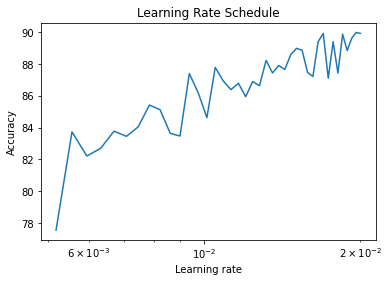

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.6425074338912964 Batch_id=97 Accuracy=36.46: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5210/10000 (52.10%)

EPOCH: 2


Loss=1.5941824913024902 Batch_id=97 Accuracy=53.43: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5944/10000 (59.44%)

EPOCH: 3


Loss=1.3246763944625854 Batch_id=97 Accuracy=59.97: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6703/10000 (67.03%)

EPOCH: 4


Loss=1.2084951400756836 Batch_id=97 Accuracy=65.16: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7120/10000 (71.20%)

EPOCH: 5


Loss=1.0318299531936646 Batch_id=97 Accuracy=68.89: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7367/10000 (73.67%)

EPOCH: 6


Loss=0.9213693737983704 Batch_id=97 Accuracy=71.66: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7613/10000 (76.13%)

EPOCH: 7


Loss=1.012942910194397 Batch_id=97 Accuracy=73.84: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7214/10000 (72.14%)

EPOCH: 8


Loss=0.8828889727592468 Batch_id=97 Accuracy=75.82: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 7998/10000 (79.98%)

EPOCH: 9


Loss=0.9273456931114197 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8070/10000 (80.70%)

EPOCH: 10


Loss=0.8492166996002197 Batch_id=97 Accuracy=78.70: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8155/10000 (81.55%)

EPOCH: 11


Loss=0.836067795753479 Batch_id=97 Accuracy=79.33: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8042/10000 (80.42%)

EPOCH: 12


Loss=0.8238868713378906 Batch_id=97 Accuracy=80.33: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8310/10000 (83.10%)

EPOCH: 13


Loss=0.7204015851020813 Batch_id=97 Accuracy=81.42: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8266/10000 (82.66%)

EPOCH: 14


Loss=0.7211740016937256 Batch_id=97 Accuracy=82.28: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8354/10000 (83.54%)

EPOCH: 15


Loss=0.7868552207946777 Batch_id=97 Accuracy=83.34: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8318/10000 (83.18%)

EPOCH: 16


Loss=0.6866307258605957 Batch_id=97 Accuracy=83.79: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8480/10000 (84.80%)

EPOCH: 17


Loss=0.6599740386009216 Batch_id=97 Accuracy=84.74: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8405/10000 (84.05%)

EPOCH: 18


Loss=0.6445391774177551 Batch_id=97 Accuracy=85.27: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8454/10000 (84.54%)

EPOCH: 19


Loss=0.7494553327560425 Batch_id=97 Accuracy=85.86: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8462/10000 (84.62%)

EPOCH: 20


Loss=0.6088313460350037 Batch_id=97 Accuracy=85.81: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8462/10000 (84.62%)

EPOCH: 21


Loss=0.7060310244560242 Batch_id=97 Accuracy=86.54: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8647/10000 (86.47%)

EPOCH: 22


Loss=0.5827869772911072 Batch_id=97 Accuracy=87.02: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8657/10000 (86.57%)

EPOCH: 23


Loss=0.643610417842865 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8654/10000 (86.54%)

EPOCH: 24


Loss=0.5401126146316528 Batch_id=97 Accuracy=87.84: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]



Test set: Average loss: 0.0008, Accuracy: 8700/10000 (87.00%)



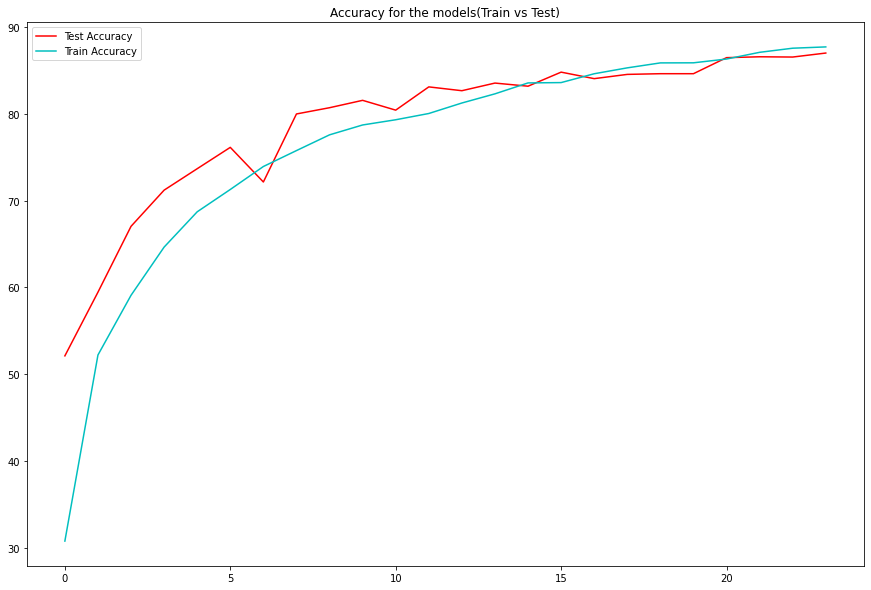

In [6]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

  main(args['classes'],args['lrate'],args['momentum'],args['batch_size'],args['EPOCHS'],args['l1'],args['l2'],args['end_lr'],args['lr_epochs'],args['step_mode'])